Notebook pour étudier la propagation/addition des erreurs entre le RNN TPDN

In [2]:
%load_ext autoreload
%autoreload 2

import os
import sys

from  GRU import GRUEncoderGD, GRUDecoderGD
from TPDN import TensorProductEncoder

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchmetrics.classification import Accuracy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
input_size = 10
emb_size = 8
hidden_size = 64

output_size = 10
num_layers = 1
batch_size = 16
seq_len = 10
epochs = 10000
learning_rate = 0.001

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device('cpu')
print( f"using {device} ")
precision= Accuracy(task="multiclass", num_classes=input_size).to(device) 

using cpu 


In [4]:
def generate_data(batch_size, seq_len, input_size):
    '''
    input_size : pour la plage de valeur 
    '''
    data = torch.randint(0, input_size, (batch_size, seq_len))  # fillers
    roles = torch.arange(seq_len).unsqueeze(0).expand(batch_size, -1)  # rôles
    return data, roles


def plot_tensors(tensor1, tensor2, labels=("Tensor 1", "Tensor 2")):

    tensor1 = tensor1.flatten()
    tensor2 = tensor2.flatten()
    x_indices = range(len(tensor1))
    plt.figure(figsize=(10, 6))
    plt.plot(x_indices, tensor1.detach().numpy(), label=labels[0], marker='o')
    plt.plot(x_indices, tensor2.detach().numpy(), label=labels[1], marker='x')
    plt.title("Comparaison des valeurs des tenseur en fonction de l'indice")
    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()

Epoch [10/10000], Loss: 2.2987, Accuracy: 11.25%
Epoch [20/10000], Loss: 2.3106, Accuracy: 6.25%
Epoch [30/10000], Loss: 2.3053, Accuracy: 10.62%
Epoch [40/10000], Loss: 2.3043, Accuracy: 7.50%
Epoch [50/10000], Loss: 2.3049, Accuracy: 8.75%
Epoch [60/10000], Loss: 2.3025, Accuracy: 9.38%
Epoch [70/10000], Loss: 2.3056, Accuracy: 6.25%
Epoch [80/10000], Loss: 2.3066, Accuracy: 11.25%
Epoch [90/10000], Loss: 2.2997, Accuracy: 9.38%
Epoch [100/10000], Loss: 2.2663, Accuracy: 11.88%
Epoch [110/10000], Loss: 2.2528, Accuracy: 14.38%
Epoch [120/10000], Loss: 2.2198, Accuracy: 18.12%
Epoch [130/10000], Loss: 2.2606, Accuracy: 13.12%
Epoch [140/10000], Loss: 2.2527, Accuracy: 15.00%
Epoch [150/10000], Loss: 2.2209, Accuracy: 14.38%
Epoch [160/10000], Loss: 2.1398, Accuracy: 18.75%
Epoch [170/10000], Loss: 2.1482, Accuracy: 18.12%
Epoch [180/10000], Loss: 2.1634, Accuracy: 21.88%
Epoch [190/10000], Loss: 2.1598, Accuracy: 17.50%
Epoch [200/10000], Loss: 2.0260, Accuracy: 21.88%
Epoch [210/1000

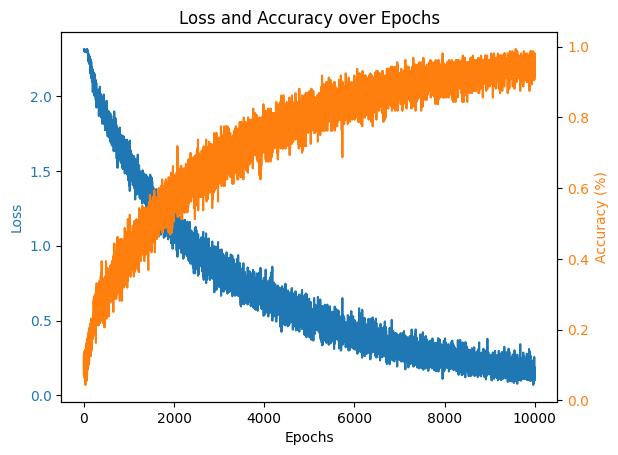

In [5]:
encoder = GRUEncoderGD(input_size, emb_size, hidden_size, num_layers).to(device)
decoder = GRUDecoderGD(emb_size, hidden_size, output_size, num_layers).to(device)

criterion = nn.CrossEntropyLoss()  # CrossEntropyLoss mieux adapté pour des classes discrètes
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=learning_rate)

losses = []
accuracies = []

for epoch in range(epochs):
    data , _ = generate_data(batch_size, seq_len, input_size)
    data = data.to(device)
    

    _, hidden = encoder(data)
    hidden = hidden.to(device)
    # print(hidden.shape)
    hidden = hidden[-1].unsqueeze(0).repeat(num_layers, 1, 1) 
    # on fait ca pour ne garder que la sortie de la couche finale et la copier pour avoir le bon nombre de couches pour le décodeur
    # si on met une seule couche dans le décodeur ca bug et on veut pas la suite de couches différentes sinon on peut pas l'utiliser avec le tpdn

    # print(hidden.shape)
    reconstructed_x = decoder(hidden, seq_len)#.argmax(dim=-1)

    loss = criterion(reconstructed_x.view(-1, output_size), data.view(-1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    accuracy = precision(reconstructed_x.argmax(dim=-1), data)
    losses.append(loss.item())
    accuracies.append(accuracy.cpu())

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}, Accuracy: {accuracy*100:.2f}%")



torch.save(encoder, "gru_enc.pth")
torch.save(decoder, "gru_dec.pth")


fig, ax1 = plt.subplots()

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='tab:blue')
ax1.plot(range(epochs), losses, color='tab:blue', label='Loss')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()  
ax2.set_ylabel('Accuracy (%)', color='tab:orange')  
ax2.plot(range(epochs), accuracies, color='tab:orange', label='Accuracy')
ax2.tick_params(axis='y', labelcolor='tab:orange')


plt.title('Loss and Accuracy over Epochs')

plt.savefig(f"training_gru_{epochs}_epochs.png")
plt.show()

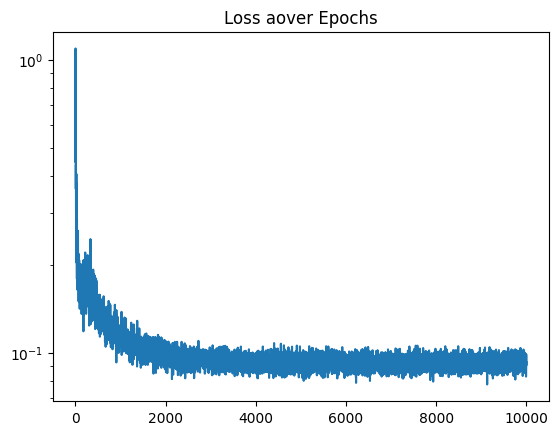

In [16]:
emb_size_tpdn =

seq_len_tensor = torch.tensor([seq_len]).to(device)


tpdnencoder = TensorProductEncoder(n_roles=seq_len, n_fillers=seq_len, filler_dim=emb_size_tpdn, role_dim=emb_size_tpdn, hidden_size=hidden_size).to(device)
tpdnencoder.train()

criterion = nn.MSELoss()
optimizer = optim.Adam(tpdnencoder.parameters(), lr=learning_rate)
epochs = 10000

encoder.eval()

losses = []
for epoch in range(epochs):
    optimizer.zero_grad()
    data, roles = generate_data(batch_size, seq_len, input_size)
    data = data.to(device)
    roles = roles.to(device)
    with torch.no_grad():  
        _, encoder_hidden = encoder(data)
    # _ , encoder_hidden = encoder(data)
    # print(encoder_hidden.shape)
    encoder_hidden = encoder_hidden[-1,:,:]
    # print(encoder_hidden.shape)
    tpdn_output = tpdnencoder(data, roles)[:,-1,:].to(device)
    # print(tpdn_output.shape)
    # reconstructed_x = decoder(tpdn_output.unsqueeze(0), seq_len_tensor)

    loss = criterion(tpdn_output, encoder_hidden)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()

torch.save(tpdnencoder, "tpdn_gru.pth")


plt.plot(losses)
plt.yscale('log')
plt.title('Loss aover Epochs')
plt.show()



torch.Size([1, 10, 64])
torch.Size([1, 1, 64])
torch.Size([1, 64])
torch.Size([1, 10, 64])
tensor([[-0.4961,  0.9046,  0.0690,  0.1296, -0.1958,  0.8915,  0.5219,  0.2124,
         -0.5590, -0.6712, -0.2864,  0.9935,  0.6466, -0.3847, -0.2663, -0.2833,
          0.9213, -0.8672,  0.9886,  0.0472,  0.7635,  0.5364,  0.1744,  0.9064,
          0.6027,  0.0716,  0.2983,  0.3176, -0.1226,  0.0124, -0.0011,  0.4910,
          0.1614, -0.9461, -0.6431, -0.1629,  0.2270,  0.1943, -0.3396,  0.1736,
         -0.3156, -0.3468,  0.9976, -0.6424, -0.6463,  0.3946,  0.5144,  0.4233,
          0.0568,  0.4958, -0.6949,  0.4129,  0.9014,  0.2668, -0.6377, -0.2745,
          0.0208,  0.2615, -0.0524,  0.1247,  0.8547,  0.9453,  0.5581, -0.1636]],
       device='cuda:0', grad_fn=<SelectBackward0>)
tensor([[-0.2947,  0.7972,  0.3436,  0.3138, -0.1860,  0.9444,  0.4705, -0.0671,
         -0.5902,  0.1235, -0.2522,  0.9995,  0.1167, -0.4623, -0.2440, -0.5678,
          0.5910, -0.5841,  0.9865,  0.0050,  

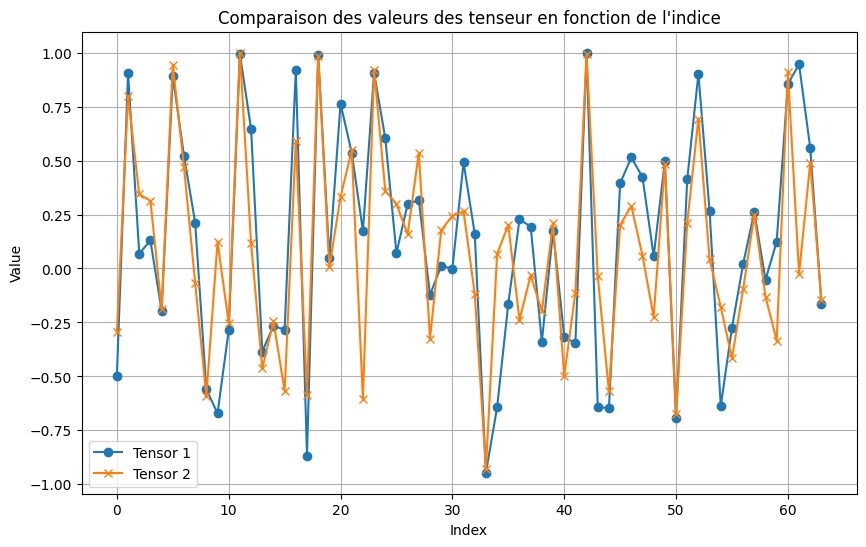

In [17]:
data , roles = generate_data(1, seq_len, input_size)
data = data.to(device)
roles = roles.to(device)
rnn_out, rnn_hidden = encoder(data)
tpdn_output= tpdnencoder(data, roles)
# tpdn_output = torch.tensor(tpdn_output)
tpdn_hidden = tpdn_output[:,-1,:]

print( rnn_out.shape)
print(rnn_hidden.shape)
print(tpdn_hidden.shape)
print(tpdn_output.shape)

print(rnn_hidden[-1])
print(tpdn_hidden)
plot_tensors(rnn_hidden[-1].cpu(), tpdn_hidden.cpu())

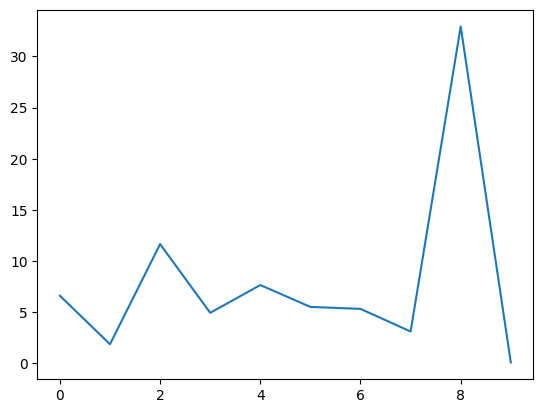

In [18]:
liste_error = []
criterion = nn.MSELoss()
for i in range(tpdn_output.shape[1]):
    liste_error.append(criterion(tpdn_output[:,i,:].cpu(), rnn_out[:,i,:].cpu()).item())

plt.plot(liste_error)

## Grid search tpdn sur GRU encoder

In [10]:
import itertools
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

os.makedirs("./models/TPDN/", exist_ok=True)
os.makedirs("./resultats/TPDN/", exist_ok=True)

input_size = 10
emb_size = 8
hidden_size = 64

output_size = 10
num_layers = 1
batch_size = 16
seq_len = 10
epochs = 20000
learning_rate = 0.001

emb_sizes_tpdn = [4, 8, 16, 32, 64, 128] 

results = []

for emb_size_tpdn in emb_sizes_tpdn:
    print(f"\n--- emb_size_tpdn={emb_size_tpdn} ---\n")

    seq_len_tensor = torch.tensor([seq_len]).to(device)

    tpdnencoder = TensorProductEncoder(
        n_roles=seq_len,
        n_fillers=seq_len,
        filler_dim=emb_size_tpdn,
        role_dim=emb_size_tpdn,
        hidden_size=hidden_size
    ).to(device)

    tpdnencoder.train()

    criterion = nn.MSELoss()
    optimizer = optim.Adam(tpdnencoder.parameters(), lr=learning_rate)

    losses = []
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        data, roles = generate_data(batch_size, seq_len, input_size)
        data = data.to(device)
        roles = roles.to(device)

        with torch.no_grad():
            _, encoder_hidden = encoder(data)
        
        encoder_hidden = encoder_hidden[-1, :, :]  
        tpdn_output = tpdnencoder(data, roles)[:, -1, :].to(device) 
        loss = criterion(tpdn_output, encoder_hidden)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()

        if (epoch + 1) % 2000 == 0:  
            print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.6f}")

  
    torch.save(tpdnencoder, f"./models/TPDN/tpdn_gru_emb{emb_size_tpdn}.pth")

    plt.figure()
    plt.plot(losses)
    plt.yscale('log')
    plt.title(f'Loss over Epochs (emb_size_tpdn={emb_size_tpdn})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.savefig(f"./resultats/TPDN/loss_tpdn_emb{emb_size_tpdn}.png")
    plt.close()

    results.append({
        "emb_size_tpdn": emb_size_tpdn,
        "final_loss": losses[-1]
    })

df_results = pd.DataFrame(results)
df_results.to_csv("./resultats/TPDN/grid_search_results_tpdn.csv", index=False)

print("\n--- tableau result svg ---")




--- emb_size_tpdn=4 ---

Epoch [2000/20000], Loss: 0.096955
Epoch [4000/20000], Loss: 0.097280
Epoch [6000/20000], Loss: 0.095675
Epoch [8000/20000], Loss: 0.100786
Epoch [10000/20000], Loss: 0.094848
Epoch [12000/20000], Loss: 0.091563
Epoch [14000/20000], Loss: 0.099035
Epoch [16000/20000], Loss: 0.102649
Epoch [18000/20000], Loss: 0.096837
Epoch [20000/20000], Loss: 0.098163

--- emb_size_tpdn=8 ---

Epoch [2000/20000], Loss: 0.092238
Epoch [4000/20000], Loss: 0.101154
Epoch [6000/20000], Loss: 0.092687
Epoch [8000/20000], Loss: 0.100736
Epoch [10000/20000], Loss: 0.102381
Epoch [12000/20000], Loss: 0.093431
Epoch [14000/20000], Loss: 0.093278
Epoch [16000/20000], Loss: 0.101958
Epoch [18000/20000], Loss: 0.094918
Epoch [20000/20000], Loss: 0.094786

--- emb_size_tpdn=16 ---

Epoch [2000/20000], Loss: 0.101028
Epoch [4000/20000], Loss: 0.093256
Epoch [6000/20000], Loss: 0.093106
Epoch [8000/20000], Loss: 0.094356
Epoch [10000/20000], Loss: 0.098440
Epoch [12000/20000], Loss: 0.0904